In [ ]:
# default_exp processor

In [ ]:
%load_ext autoreload
%autoreload 2

# cheviz processor

The idea of our processor is to take a game and process it into a useful, annotated format Pandas could consume. This should help with our analysis and later on ML training.

In [ ]:
#export
from typing import Callable
import pandas as pd
import numpy as np
import chess.engine
import cheviz.core as cco
import cheviz.data as cda
import cheviz.stockfish as cst

The [python-chess example](https://python-chess.readthedocs.io/en/latest/engine.html) shows us how to get stockfish to score a given position.

engine score: #+1


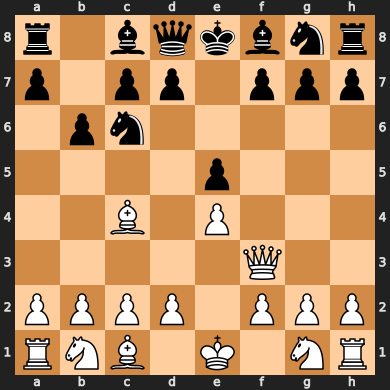

In [ ]:
engine = cst.makeEngine()()
board = chess.Board("r1bqkbnr/p1pp1ppp/1pn5/4p3/2B1P3/5Q2/PPPP1PPP/RNB1K1NR w KQkq - 2 4")
info = engine.analyse(board, chess.engine.Limit(depth=20))
engine.quit()

print('engine score:', info['score'])
display(board)

Let's process the first game from the Candidates tournament 1953.

In [ ]:
games = list(cda.games(cda.fetch()['Candidates_1953.pgn']))
games[0].headers, games[0].moves

(Headers(Event='ct', Site='Zurich', Date='1953.??.??', Round='01', White='Szabo L', Black='Geller E', Result='0-1'),
 <Mainline at 0x7ff1e2e30048 (1. c4 Nf6 2. g3 e6 3. Bg2 d5 4. d4 dxc4 5. Qa4+ Nbd7 6. Nf3 a6 7. Qxc4 b5 8. Qc6 Rb8 9. Bf4 Nd5 10. Bg5 Be7 11. Bxe7 Qxe7 12. O-O Bb7 13. Qc2 c5 14. dxc5 Nxc5 15. Rc1 Rc8 16. Nc3 Nf6 17. b4 Na4 18. Qb3 Nxc3 19. Rxc3 Rxc3 20. Qxc3 O-O 21. Rc1 Rd8 22. a3 Nd5 23. Qd4 f6 24. Ne1 e5 25. Qc5 Qxc5 26. bxc5 Bc6 27. Rd1 Rd7 28. Bh3 Re7 29. Nc2 a5 30. Bg2 Rd7 31. Bh3 Re7 32. Kf1 Kf7 33. Ke1 Rc7 34. Rd3 Bb7 35. Ne3 Rxc5 36. Nf5 Bc6 37. Nd6+ Kf8 38. Bg2 g6 39. Kd2 Ke7 40. Ne4 Rc4 41. f3 f5 42. Nf2 Ra4 43. Nd1 e4 44. fxe4 fxe4 45. Rb3 Rd4+ 46. Kc1 b4 47. Ne3 Nc3 48. axb4 Nxe2+ 49. Kb1 Ba4 50. Rb2 Nc3+ 51. Kc1 axb4 52. Rd2 Rxd2 53. Kxd2 Kd6 54. Ng4 Kc5 55. h4 Kd4 56. h5 gxh5 57. Ne3 Nb1+ 58. Ke2 Bb5+ 59. Kf2 b3)>)

I still need to figure out how to safely do RAII with Python, hence the clumsy `engine_maker` stuff. Python's `with ... as ...:` looks promising.

In [ ]:
#export
class Processor:
    def __init__(self, engine_maker:Callable, game:cda.Game, first_move_by_white=True):
        self.engine_maker = engine_maker
        self.moves = list(game.moves)
        self.first_move_by_white = first_move_by_white
        # FIXME: Fix makeMoveSequencer to indicate that each side needs its own instance,
        # due to how the square filter works (hint: shared board instance).
        self.msw = cda.makeMoveSequencer(self.moves)
        self.msb = cda.makeMoveSequencer(self.moves)
        self.msz = cda.makeMoveSequencer(self.moves)


    def run(self, reduced:Callable, square_filter:Callable, echo:int=1, depth:int=20)->pd.DataFrame:
        engine = self.engine_maker()
        result = pd.DataFrame(columns=['SideThatMoved', 'SideToMove',
                                       'Score', 'PovScore',
                                       'HalfMoveConfiguration', 'FEN',
                                       'LastWhiteMove', 'LastBlackMove',
                                       'ViewForWhite', 'ViewForBlack',
                                       'Zeros', 'ZerosWithEcho'])

        for curr_move in range(0, len(self.moves)):
            bm_offset = (curr_move + 1) % 2
            adjusted_wm = (curr_move // 2) * 2
            adjusted_bm = curr_move - bm_offset
        
            side = bool(bm_offset) # white: 1, black: 0, same as in python-chess
            if not self.first_move_by_white:
                adjusted_wm, adjusted_bm = adjusted_bm, adjusted_wm # not tested!
            
            last_white_move = self.moves[adjusted_wm]
            last_black_move = self.moves[adjusted_bm] if adjusted_bm > -1 else None
        
            white = self.msw(range(adjusted_wm - (echo * 2) , adjusted_wm + 1), chess.WHITE, square_filter)
            black = self.msb(range(adjusted_bm - (echo * 2), adjusted_bm + 1), chess.BLACK, square_filter)
            zeros_white = reduced(self.msz(range(curr_move, curr_move + 1), chess.WHITE, square_filter).result)
            zeros_black = reduced(self.msz(range(curr_move, curr_move + 1), chess.BLACK, square_filter).result)

            reduced_white = reduced(white.result)
            reduced_black = reduced(black.result)
            
            # would be nice if engine.analyse could be made to run async/in parallel
            current_board = white.board if side else black.board
            score = engine.analyse(current_board, chess.engine.Limit(depth=depth))['score']
        
            result.loc[curr_move] = ['White' if side else 'Black',
                                     'Black' if side else 'White',
                                     int(score.pov(chess.WHITE).__str__()),
                                     int(score.pov(score.turn).__str__()),
                                     (curr_move, adjusted_wm, adjusted_bm),
                                     current_board.fen(), last_white_move, last_black_move,
                                     reduced_white, reduced_black,
                                     cda.countZeros(np.logical_or(zeros_white, zeros_black)),
                                     cda.countZeros(np.logical_or(reduced_white, reduced_black))]

        engine.quit() # This is important, otherwise we leak opened file objects!
        return result

In [ ]:
proc = Processor(cst.makeEngine(), games[0])
data = proc.run(cda.diffReduce, cco.attack, 4)

We now have a dataframe of positions, each analyzed by stockfish. It's probably pointless to try to teach Pandas to use proper types for its columns. Just keep in mind that the string representation as shown by `pd.DataFrame.head()` lies to you and that additional marshalling might be needed to work with the data.

In [ ]:
data.head(10)

,SideThatMoved,SideToMove,Score,PovScore,HalfMoveConfiguration,FEN,LastWhiteMove,LastBlackMove,ViewForWhite,ViewForBlack,Zeros,ZerosWithEcho
0,White,Black,-23,23,"(0, 0, -1)",rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR ...,c2c4,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44,44
1,Black,White,72,72,"(1, 0, 1)",rnbqkb1r/pppppppp/5n2/8/2P5/8/PP1PPPPP/RNBQKBN...,c2c4,g8f6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...",41,41
2,White,Black,-2,2,"(2, 2, 1)",rnbqkb1r/pppppppp/5n2/8/2P5/6P1/PP1PPP1P/RNBQK...,g2g3,g8f6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...",39,47
3,Black,White,69,69,"(3, 2, 3)",rnbqkb1r/pppp1ppp/4pn2/8/2P5/6P1/PP1PPP1P/RNBQ...,g2g3,e7e6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",36,52
4,White,Black,-26,26,"(4, 4, 3)",rnbqkb1r/pppp1ppp/4pn2/8/2P5/6P1/PP1PPPBP/RNBQ...,f1g2,e7e6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",35,48
5,Black,White,21,21,"(5, 4, 5)",rnbqkb1r/ppp2ppp/4pn2/3p4/2P5/6P1/PP1PPPBP/RNB...,f1g2,d7d5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",34,45
6,White,Black,14,-14,"(6, 6, 5)",rnbqkb1r/ppp2ppp/4pn2/3p4/2PP4/6P1/PP2PPBP/RNB...,d2d4,d7d5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",31,39
7,Black,White,76,76,"(7, 6, 7)",rnbqkb1r/ppp2ppp/4pn2/8/2pP4/6P1/PP2PPBP/RNBQK...,d2d4,d5c4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",31,37
8,White,Black,-10,10,"(8, 8, 7)",rnbqkb1r/ppp2ppp/4pn2/8/Q1pP4/6P1/PP2PPBP/RNB1...,d1a4,d5c4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",26,31
9,Black,White,13,13,"(9, 8, 9)",r1bqkb1r/pppn1ppp/4pn2/8/Q1pP4/6P1/PP2PPBP/RNB...,d1a4,b8d7,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27,29


HalfMoveConfiguration tells us which half move was evaluated. Since we are interested in views for each side, the half moves are adjusted for each side, too. The triple `(3, 2, 3)` tells us that the row we look at is the result after half move 3 got executed. Since we are zero-started and white was to move first, this is a black move (see `SideThatMoved`). We see that the last element of the triple is 3, the same as our half move. The second element is still at 2, however, showing that the positional view for white in this row was derived from half move 2. This is also what the `Last{White,Black}Move` columns try to tell us. We can reconstruct the board using the FEN column like so:

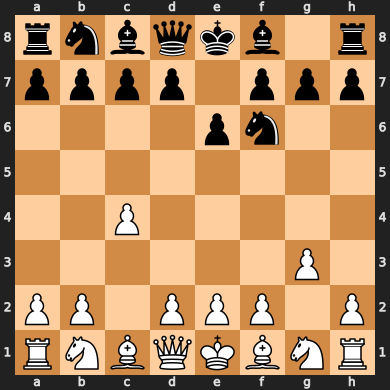

In [ ]:
chess.Board(data.loc[3, 'FEN'])

It's important to read `PovScore` (point-of-view score) in combination with `SideToMove` – that's just how chess engines work. The ability to move in a given position is highly valuable to a chess engine unless, of course, you are under [Zugzwang](https://en.wikipedia.org/wiki/Zugzwang).

In [ ]:
data.loc[3, ['SideToMove', 'PovScore']]

SideToMove    White
PovScore         69
Name: 3, dtype: object

Notice that as a result of our `HalfMoveConfiguration` semantics, the `ViewFor{White,Black}` columns only change with every other move. This is intentional. Our move echo filters positions for each side so that a move echo of 4 considers the last 4 postions after a side moved, going back a total of 8 half moves in the move sequence. Without position filtering, move echo becomes a "noisy" metric. That doesn't necessarily mean it's worse but the extra "noise" can be confusing to a human. Comparing the two versions (and deciding which is easier to "understand" for a machine) is future work.

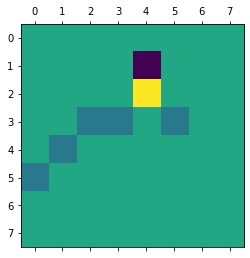

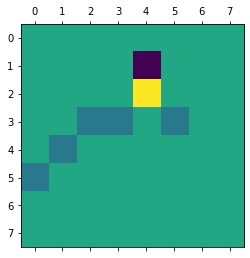

In [ ]:
cco.show(data.loc[3, 'ViewForBlack']), cco.show(data.loc[4, 'ViewForBlack']);

Obviously, them being Numpy arrays, we can trivially combine those arrays.

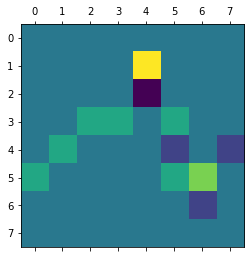

In [ ]:
cco.show(data.loc[3, 'ViewForWhite'] - data.loc[3, 'ViewForBlack']);

We can filter the dataframe by side.

In [ ]:
data[data['SideThatMoved'] == 'White'].head(5)

,SideThatMoved,SideToMove,Score,PovScore,HalfMoveConfiguration,FEN,LastWhiteMove,LastBlackMove,ViewForWhite,ViewForBlack,Zeros,ZerosWithEcho
0,White,Black,-23,23,"(0, 0, -1)",rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR ...,c2c4,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44,44
2,White,Black,-2,2,"(2, 2, 1)",rnbqkb1r/pppppppp/5n2/8/2P5/6P1/PP1PPP1P/RNBQK...,g2g3,g8f6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...",39,47
4,White,Black,-26,26,"(4, 4, 3)",rnbqkb1r/pppp1ppp/4pn2/8/2P5/6P1/PP1PPPBP/RNBQ...,f1g2,e7e6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",35,48
6,White,Black,14,-14,"(6, 6, 5)",rnbqkb1r/ppp2ppp/4pn2/3p4/2PP4/6P1/PP2PPBP/RNB...,d2d4,d7d5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",31,39
8,White,Black,-10,10,"(8, 8, 7)",rnbqkb1r/ppp2ppp/4pn2/8/Q1pP4/6P1/PP2PPBP/RNB1...,d1a4,d5c4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",26,31


The `Zeros` column indicates how well the board is covered by pieces. If the attack filter is used then higher values roughly mean that the pieces on the board control fewer squares. The maximum of `Zeros` would equal all squares on an empty chess board, 64. Our move echo – in combination with the reduce filter – can massively influence that metric (`ZerosWithEcho`).

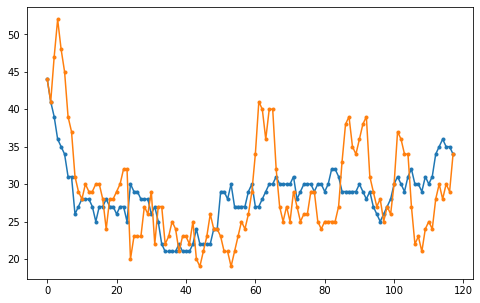

In [ ]:
data['Zeros'].plot(style='.-', figsize=(8, 5))
data['ZerosWithEcho'].plot(style='.-');

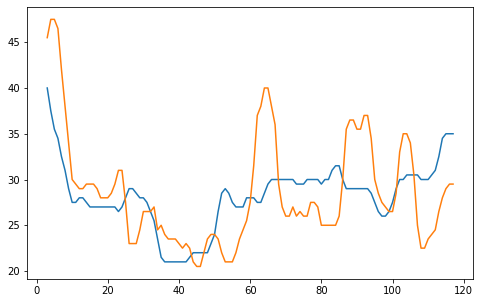

In [ ]:
data['Zeros'].rolling(4).median().plot(figsize=(8, 5))
data['ZerosWithEcho'].rolling(4).median().plot();

Let's plot the [centipawn score](https://chess.fandom.com/wiki/Centipawn). Here we plot it separately for each side.

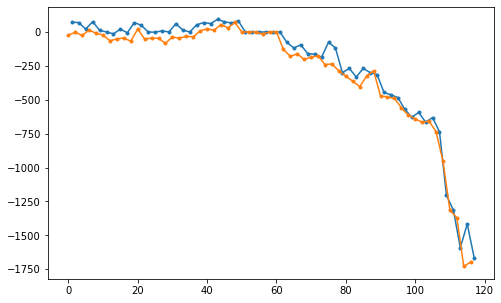

In [ ]:
data[data['SideToMove'] == 'White']['Score'].plot(style='.-', figsize=(8, 5))
data[data['SideToMove'] == 'Black']['Score'].plot(style='.-');

We can also see how strongly the score changes between positions.

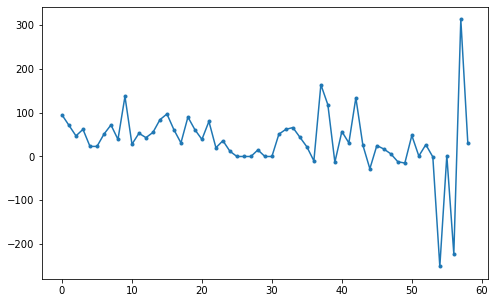

In [ ]:
pd.Series(data[data['SideToMove'] == 'White']['Score'].to_numpy()
          - data[data['SideToMove'] == 'Black']['Score'].to_numpy()).plot(style='.-', figsize=(8, 5));

As visual comparison, the rolling/expanding window version:

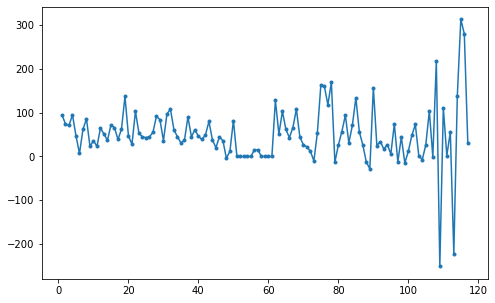

In [ ]:
data['PovScore'].expanding(2).agg(lambda x: x[x.index[-1]] + x[x.index[-2]]).plot(style='.-', figsize=(8, 5));

The main difference to the previous plot is that our xticks are half moves instead of full moves.

Here is an example of how you can read data from a row that you find interesting. The row index is the half move of the analyzed position.

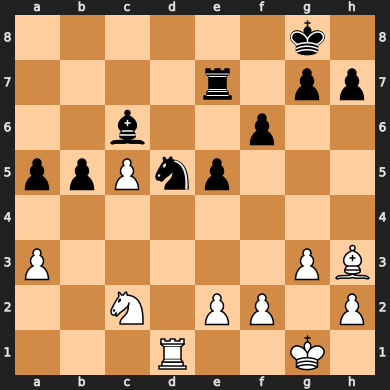

0

'White'

None

None

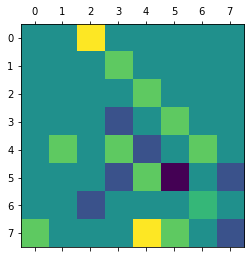

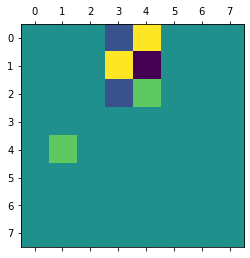

In [ ]:
row = data.loc[61]
display(chess.Board(row['FEN']), row['PovScore'], row['SideToMove'], cco.show(row['ViewForWhite']), cco.show(row['ViewForBlack']))